In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

### 1. Import Data

In [28]:
df = pd.read_csv('apple_quality.csv').dropna()

### 2. Exploratory Data Analysis

In [29]:
display(df.head())
display(df.info()) 

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 312.5+ KB


None

### 3. Data Processing

In [30]:
#Encoding the Quality Catogical Data
df['Quality'] = LabelEncoder().fit_transform(df['Quality'])

#Split Dataset into input and output vectors/matrixes
X_df, y_df = df.drop(['Quality', 'A_id'], axis=1).astype(float), df['Quality'].astype(float) #remove apple ID number (not needed for model)

#Convert to numpy array
X, y = X_df.values, y_df.values

#Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Standardize Data

In [31]:
#Standardizing Input Values
scaler = StandardScaler() 
X_train, X_test  = scaler.fit_transform(X_train), scaler.fit_transform(X_test)
# Normalizing yielded a lower accuracy than standardizing, hence I picked standardization
# Normalization was likely less accurate due to the higher range of values in the apple_quality csv file. 

#Converting to tensors
X_train, X_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float()
y_train, y_test = torch.from_numpy(y_train).long(), torch.from_numpy(y_test).long()

### 5. Creating FNN

In [32]:
num_features = len(X_df.columns)

class net(nn.Module):
    def __init__(self, features = num_features, h1 = 64, h2 = 128, h3 = 64, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(num_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)

        return x

In [33]:
# Pick a seed
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = net().to(device)

### 6. CrossEntropyLoss and the Adam Optimizer

In [34]:
#Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### 7. Loss

In [35]:
epochs = 201
losses = []

for i in range(epochs):
    y_pred = model(X_train)

    #measuring loss/error
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())

    # forward + backward + optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(f'Epoch: {i} and loss: {loss}')

Epoch: 0 and loss: 0.6949917674064636
Epoch: 10 and loss: 0.3062742054462433
Epoch: 20 and loss: 0.24599362909793854
Epoch: 30 and loss: 0.1954539269208908
Epoch: 40 and loss: 0.16188476979732513
Epoch: 50 and loss: 0.1284252107143402
Epoch: 60 and loss: 0.10251106321811676
Epoch: 70 and loss: 0.10110180079936981
Epoch: 80 and loss: 0.08465796709060669
Epoch: 90 and loss: 0.05394240468740463
Epoch: 100 and loss: 0.040018230676651
Epoch: 110 and loss: 0.028254669159650803
Epoch: 120 and loss: 0.018131248652935028
Epoch: 130 and loss: 0.01175391674041748
Epoch: 140 and loss: 0.007952790707349777
Epoch: 150 and loss: 0.005644353572279215
Epoch: 160 and loss: 0.004073439631611109
Epoch: 170 and loss: 0.0030888724140822887
Epoch: 180 and loss: 0.0024238629266619682
Epoch: 190 and loss: 0.0019493113504722714
Epoch: 200 and loss: 0.0016079291235655546


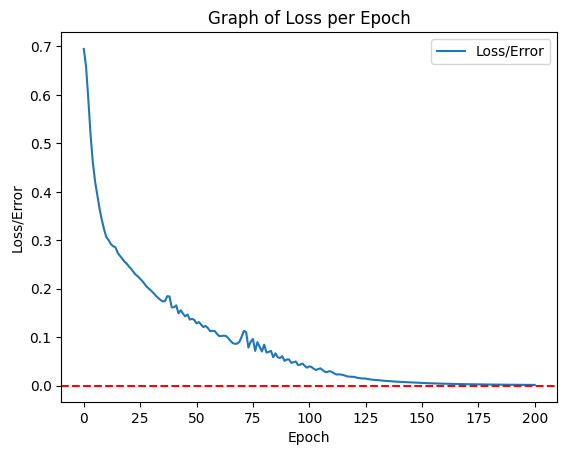

In [36]:
#Plotting Loss Curver
plt.plot(range(epochs), losses, label='Loss/Error')
plt.axhline(y=0, color='r', linestyle='--') 
plt.title("Graph of Loss per Epoch")
plt.ylabel("Loss/Error")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### 8. Accuracy

In [37]:
model.eval() #Turn model to evaluation mode

with torch.no_grad():
    y_pred_test = model(X_test.to(device))
    _, predicted = torch.max(y_pred_test.data, 1)

# Classification_report
results = classification_report(y_test, predicted)

print(results)
print("Hence, the accuracy of the model is about 93%")

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       401
           1       0.93      0.92      0.93       399

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800

Hence, the accuracy of the model is about 93%
